Fit interpretable models to the training set and test on validation sets.

In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.interpolate import interp1d

import imodels
from imodels.experimental import stablelinear
from rulevetting.api import validation
from rulevetting.projects.csi_pecarn.dataset import Dataset
from sklearn.metrics import classification_report, confusion_matrix

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
df_train, df_tune, df_test = Dataset().get_data()
# X_train = df_train.drop(columns=[outcome_def, 'SITE'])
X_train = df_train.drop(columns=[outcome_def])
y_train = df_train[outcome_def].values
# X_tune = df_tune.drop(columns=[outcome_def, 'SITE'])
X_tune = df_tune.drop(columns=[outcome_def])
y_tune = df_tune[outcome_def].values
# X_test = df_test.drop(columns=[outcome_def, 'SITE'])
X_test = df_test.drop(columns=[outcome_def])
y_test = df_test[outcome_def].values
processed_feats = X_train.keys().values.tolist()
feature_names = processed_feats

def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x.values)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

def baseline_cdr_predict(X, use_2 = False):
    num_conditions = (X['AlteredMentalStatus2'] + 
                      X['FocalNeuroFindings2'] + 
                      X['PainNeck2'] +
                      X['Torticollis2'] + 
                      X['subinj_TorsoTrunk2'] + 
                      X['Predisposed'] + 
                      X['HighriskDiving'] + 
                      X['HighriskMVC'])
    preds = (num_conditions > 0).astype(int).values
    return preds

def simple_report(y_true, y_pred, verbose=True):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    if verbose:
        print(classification_report(y_true, y_pred))
        print("Specificity: ", specificity)
        print("Sensitivity: ", sensitivity)
    return sensitivity, specificity

kwargs {'clean_data': {'include_intervention': True}, 'preprocess_data': {'unclear_feat_default': 0, 'only_site_data': False, 'use_control_type': 'all'}, 'extract_features': {'drop_negative_columns': False}}


In [14]:
model = DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 1000})
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_tune.values)

def spec_at_sensLevel(y, y_pred_proba, sens_level=0.98):
    all_stats, _ = validation.all_stats_curve(y, y_pred_proba)
    sens, spec = all_stats['sens'], all_stats['spec']
    if np.max(sens) < sens_level:
        sens = np.concatenate((sens, [1.0]))
        spec = np.concatenate((spec, [0.0]))
    specAtLevel = interp1d(sens, spec, fill_value='extrapolate')([sens_level])
    return specAtLevel.item()


def rel_spec_to_baseline(X, y, y_pred_proba):
    y_pred_base = baseline_cdr_predict(X)
    sens_base, spec_base = simple_report(y, y_pred_base, verbose=False)
    spec_model_at_base = spec_at_sensLevel(y, y_pred_proba[:, 1], sens_level=sens_base)
    return spec_model_at_base / spec_base

rel_spec_to_baseline(X_tune, y_tune, y_pred_prob)

/accounts/campus/albert_qu/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 9/9 [00:00<00:00, 2436.50it/s]


0.378947368421052

## Basic Stability Check with Vflow

In [16]:
from vflow import init_args, Vset, dict_to_df
import sklearn 
# initialize data
def stability_pipeline(X_train, X_tune, X_test, y_train, y_tune, y_test):
    X_train, X_test, y_train, y_test = init_args(
        (pd.concat((X_train, X_tune)), X_test, np.concatenate((y_train, y_tune)), y_test),
        names=['X_train', 'X_test', 'y_train', 'y_test']  # optionally name the args
    )

    # subsample data
    subsampling_funcs = [
        sklearn.utils.resample for _ in range(10)
    ]
    subsampling_set = Vset(name="subsampling",
                           modules=subsampling_funcs,
                           output_matching=True)
    X_trains, y_trains = subsampling_set(X_train, y_train)

    # fit models
    # TODO: Change the model opetions here to include more models
    dt = DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 1000})
    rulefit = imodels.RuleFitClassifier(alpha=20, max_rules=None, random_state=0, tree_size=3, n_estimators=50)
    skope = imodels.SkopeRulesClassifier(precision_min=0.01, recall_min=0.1, n_estimators=10, max_samples=0.8, 
                                         bootstrap=True, max_depth=3, random_state=0)
    boost = imodels.BoostedRulesClassifier(n_estimators=10)
    #saps = imodels.SaplingSumClassifier(max_rules=20)
    weak_learners = [rulefit, skope, boost]
    stbl = stablelinear.StableLinearClassifier(weak_learners=weak_learners, max_complexity=-1, alpha=0.1,
                                               max_rules=None, penalty='l1')

    models = [dt, rulefit, skope, boost, stbl] # boost, saps
    modeling_set = Vset(name="modeling",
                        modules=models,
                        module_keys=["DT", 'rulefit', 'skope', 'boostedrules','stbl']) # , 'boostedrules', 'saps'

    # models = {'DT': DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 1000})}
    # modeling_set = Vset(name="modeling", modules=models)
    modeling_set.fit(X_trains, y_trains)
    pred_proba_test = modeling_set.predict_proba(X_test)

    # get metrics
    relative_metrics_set = Vset(name='relative_metrics',
                              modules=[rel_spec_to_baseline],
                              module_keys=["relSpecToBase"])
    relative_metrics = relative_metrics_set.evaluate(X_test, y_test, pred_proba_test)
    return dict_to_df(relative_metrics)
stab_output = stability_pipeline(X_train, X_tune, X_test, y_train, y_tune, y_test)
stab_output['modeling'] = stab_output['modeling'].astype(str)

100%|██████████| 200/200 [00:00<00:00, 2634.27it/s]


Text(0.5, 1.0, 'Relative Specificity of Models to Baseline Rule at fixed Sensitivity Level')

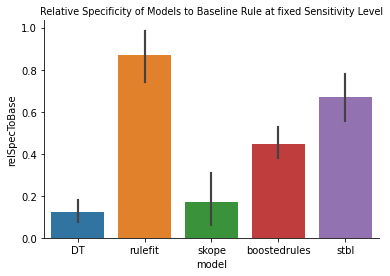

In [17]:
ax = plt.gca()
sns.set_context('paper')
sns.barplot(x='model', y='relSpecToBase', data=pd.DataFrame(stab_output[['modeling', 'out']].values, columns=['model', 'relSpecToBase']), ax=ax)
sns.despine()
ax.set_title("Relative Specificity of Models to Baseline Rule at fixed Sensitivity Level")

# fit simple models

**decision tree**

/accounts/campus/albert_qu/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 9/9 [00:00<00:00, 1249.50it/s]
/accounts/campus/albert_qu/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 8/8 [00:00<00:00, 1513.92it/s]


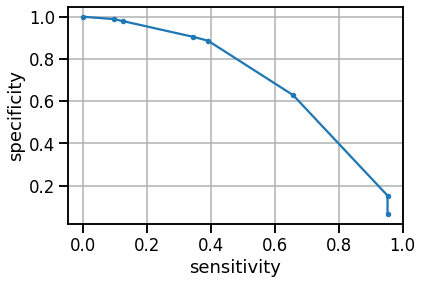

<Figure size 3600x2880 with 0 Axes>

In [57]:
# fit decition tree
dt = DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 1000})
dt.fit(X_train, y_train)
stats, threshes = predict_and_save(dt, model_name='decision_tree')
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
plt.show()

fig = plt.figure(figsize=(50, 40))
# plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

**rulefit**

100%|██████████| 68/68 [00:00<00:00, 1397.65it/s]


'\ndef print_best(sens, spec):\n    idxs = np.array(sens) > 0.9\n    print(np.array(sens)[idxs], np.array(spec)[idxs])\nprint_best(sens, spec)\n'

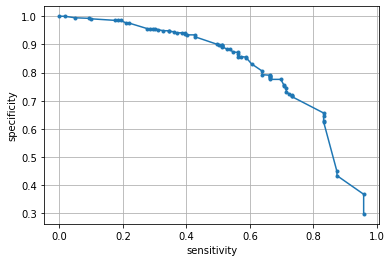

In [227]:
# fit a rulefit model
np.random.seed(13)
rulefit = imodels.RuleFitClassifier(alpha=20, max_rules=None, random_state=0, tree_size=3, n_estimators=50)
rulefit.fit(X_train, y_train, feature_names=feature_names)

# preds = rulefit.predict(X_test)
stats, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''

In [228]:
# pd.reset_option('display.max_colwidth')
rulefit.visualize()

,rule,coef
24,PainNeck2,0.27
32,is_ems,-0.10
49,Torticollis2 <= 0.5 and FocalNeuroFindings <= 0.5,-0.04
53,SubInj_TorsoTrunk <= 0.5 and FocalNeuroFindings2 <= 0.5,-0.03
52,FocalNeuroFindings <= 0.5 and Immobilization2 <= 0.5,-0.59
54,FocalNeuroFindings2 <= 0.5 and Torticollis2 <= 0.5,-0.58
50,AlteredMentalStatus <= 0.5 and HighriskDiving <= 0.5,-0.38
48,FocalNeuroFindings2 <= 0.5 and subinj_TorsoTrunk2 <= 0.5,-0.14
51,subinj_TorsoTrunk2 <= 0.5 and MedsRecd2 <= 0.5,-0.41
47,HighriskDiving <= 0.5 and FocalNeuroFindings <= 0.5 and MedsRecd2 <= 0.5,-0.43


In [170]:
X_train.columns

Index(['AlteredMentalStatus', 'LOC', 'ambulatory', 'FocalNeuroFindings',
       'PainNeck', 'PosMidNeckTenderness', 'TenderNeck', 'Torticollis',
       'SubInj_Head', 'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk',
       'Predisposed', 'HighriskDiving', 'HighriskFall', 'HighriskHanging',
       'HighriskHitByCar', 'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc',
       'axialloadtop', 'Clotheslining', 'AlteredMentalStatus2',
       'FocalNeuroFindings2', 'PainNeck2', 'PosMidNeckTenderness2',
       'TenderNeck2', 'Torticollis2', 'subinj_Head2', 'subinj_Face2',
       'subinj_Ext2', 'subinj_TorsoTrunk2', 'is_ems', 'Position_IDEMS',
       'Position_L', 'Position_ND', 'Position_PA', 'Position_S', 'Position_W',
       'Immobilization2', 'MedsRecd', 'MedsRecd2', 'gender_F', 'age_infant',
       'age_preschool', 'age_school_age', 'age_adolescents'],
      dtype='object')

### original CDR

In [173]:
X_all = pd.concat((X_train, X_tune, X_test))
y_all = np.concatenate((y_train, y_tune, y_test), axis=0)

In [175]:
simple_report(y_train, baseline_cdr_predict(X_train))

              precision    recall  f1-score   support

           0       0.98      0.33      0.49      1690
           1       0.20      0.97      0.33       297

    accuracy                           0.42      1987
   macro avg       0.59      0.65      0.41      1987
weighted avg       0.87      0.42      0.47      1987

Specificity:  0.32840236686390534
Sensitivity:  0.9696969696969697


In [176]:
print(simple_report(y_tune, baseline_cdr_predict(X_tune)))

              precision    recall  f1-score   support

           0       0.98      0.31      0.47       544
           1       0.24      0.97      0.38       119

    accuracy                           0.43       663
   macro avg       0.61      0.64      0.43       663
weighted avg       0.85      0.43      0.46       663

Specificity:  0.3125
Sensitivity:  0.9747899159663865
None


## skope

100%|██████████| 79/79 [00:00<00:00, 2745.80it/s]


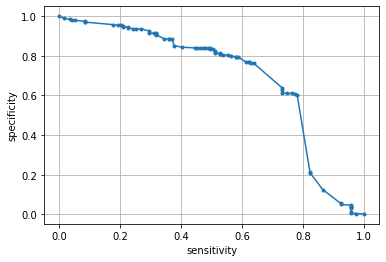

In [177]:
skope = imodels.SkopeRulesClassifier(precision_min=0.01, recall_min=0.1, n_estimators=10, max_samples=0.8, bootstrap=True, max_depth=3, random_state=0)
skope.fit(X_train, y_train)
stats, threshes = predict_and_save(skope, model_name='skope')

In [178]:
len(skope.rules_)

32

100%|██████████| 34/34 [00:00<00:00, 2131.28it/s]


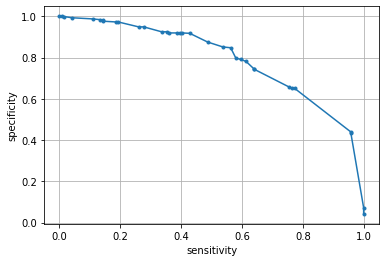

In [179]:
boost = imodels.BoostedRulesClassifier(n_estimators=10,)
boost.fit(X_train, y_train)
stats, threshes = predict_and_save(boost, model_name='boostedrules')

In [180]:
[(r, w) for r, w in boost.rules_]

[('X_4 <= 0.5', [-0.6688624108766362]),
 ('X_4 > 0.5', [-0.05433598965982746]),
 ('X_24 <= 0.5', [-0.04986204297175624]),
 ('X_24 > 0.5', [0.16669665172590226]),
 ('X_42 <= 0.5', [0.0004916657999864158]),
 ('X_42 > 0.5', [0.09204802961583503]),
 ('X_42 <= 0.5', [-0.03711634992984835]),
 ('X_42 > 0.5', [0.1077013397217912]),
 ('X_25 <= 0.5', [-0.011292298725682005]),
 ('X_25 > 0.5', [0.06203906386952975]),
 ('X_1 <= 0.5', [0.005015560593205639]),
 ('X_1 > 0.5', [0.06383028106266572]),
 ('X_1 <= 0.5', [-0.016732865294028038]),
 ('X_1 > 0.5', [0.054051497197973]),
 ('X_28 <= 0.5', [0.0028800076773283]),
 ('X_28 > 0.5', [0.04824807587681254]),
 ('X_28 <= 0.5', [-0.005071578416136064]),
 ('X_28 > 0.5', [0.0476368805399618]),
 ('X_38 <= 0.5', [0.016919204274815525]),
 ('X_38 > 0.5', [-0.07296117510291955])]

100%|██████████| 60/60 [00:00<00:00, 2383.44it/s]


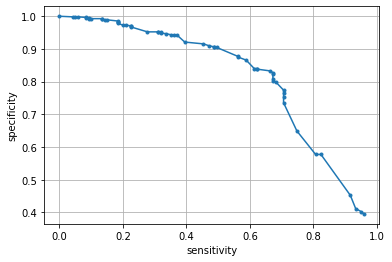

In [181]:
saps = imodels.SaplingSumClassifier(max_rules=20)
saps.fit(X_train.values, y_train, feature_names=feature_names)
stats, threshes = predict_and_save(saps, model_name='saps')

In [182]:
print(saps)

------------
FocalNeuroFindings <= 0.500 (Tree #0 root)
	SubInj_TorsoTrunk <= 0.500 (split)
		HighriskMVC <= 0.500 (split)
			FocalNeuroFindings2 <= 0.500 (split)
				Val: 0.092 (leaf)
				MedsRecd2 <= 0.500 (split)
					is_ems <= 0.500 (split)
						Val: 1.004 (leaf)
						Val: 0.127 (leaf)
					gender_F <= 0.500 (split)
						Val: 0.706 (leaf)
						Val: 0.017 (leaf)
			Val: 0.191 (leaf)
		subinj_Head2 <= 0.500 (split)
			Val: 0.198 (leaf)
			Val: 0.479 (leaf)
	AxialLoadAnyDoc <= 0.500 (split)
		Val: 0.368 (leaf)
		Val: 0.569 (leaf)

	+
MedsRecd2 <= 0.500 (Tree #1 root)
	Immobilization2 <= 0.500 (split)
		is_ems <= 0.500 (split)
			Val: 0.028 (leaf)
			Val: -0.057 (leaf)
		PainNeck <= 0.500 (split)
			Val: 0.014 (leaf)
			Position_S <= 0.500 (split)
				Val: 0.607 (leaf)
				Val: -0.297 (leaf)
	PainNeck2 <= 0.500 (split)
		Predisposed <= 0.500 (split)
			Val: 0.018 (leaf)
			Val: 0.760 (leaf)
		Position_S <= 0.500 (split)
			Val: 0.316 (leaf)
			Val: -0.228 (leaf)

	+
HighriskDiving 

In [183]:
stats['spec'][1], stats['sens'][1]

(0.4025735294117647, 0.9495798319327731)

## neural net

In [184]:
from sklearn.neural_network import MLPClassifier

/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 1697/1697 [00:00<00:00, 2080.79it/s]
/Users/keyan/anaconda3/envs/rulevet/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 628/628 [00:00<00:00, 2927.46it/s]


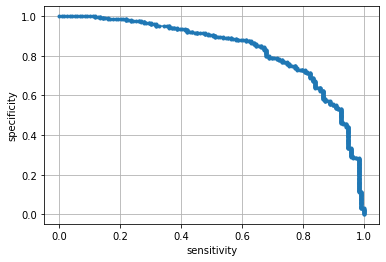

In [185]:
nn = MLPClassifier(hidden_layer_sizes=(100, ))
nn.fit(X_train, y_train)
stats, threshes = predict_and_save(nn, model_name='nn')

**GOSDT**

In [186]:
# gosdt_costs = np.array([[0.0, 0.5],
#                         [0.1, 0.0]])
# gosdt_costs_df = pd.DataFrame(gosdt_costs, columns=[0, 1])
# gosdt_costs_path = oj(MODELS_DIR, 'gosdt_costs.csv')
# gosdt_costs_df.to_csv(gosdt_costs_path)

In [187]:
# gosdt = imodels.OptimalTreeClassifier(regularization=0.01, 
#                                       cancellation=False,
#                                       look_ahead=False,
#                                       similar_support=False,
#                                       feature_exchange=False,
#                                       continuous_feature_exchange=False,
#                                       balance=False, time_limit=5)#, costs=gosdt_costs_path)
# gosdt.fit(X_train, y_train, feature_names=feature_names)
# print(gosdt)

# simple_report(y_tune, gosdt.predict(X_tune))

In [188]:
# print(str(gosdt.tree_))

**CORELS**

In [189]:
# corels = imodels.OptimalRuleListClassifier(
#     c=0.001, n_iter=100000, map_type="prefix", policy="curious", verbosity=[], ablation=0, max_card=2, min_support=0.2, random_state=0)
# corels.fit(X_train, y_train, feature_names=feature_names)
# stats, threshes = predict_and_save(corels, model_name='corels')
# print(corels)

# print(classification_report(y_tune, gosdt.predict(X_tune)))
# tn, fp, fn, tp = confusion_matrix(y_tune, gosdt.predict(X_tune)).ravel()
# specificity = tn / (tn+fp)
# print("Specificity: ", specificity)

### Stablerules

In [191]:
weak_learners = [rulefit, skope, boost]

In [213]:
stbl = stablelinear.StableLinearClassifier(weak_learners=weak_learners, max_complexity=-1, alpha=0.1, max_rules=None, penalty='l1')
stbl.fit(X_train, y_train)

StableLinearClassifier(alpha=0.1, max_complexity=-1, max_rules=None,
                       weak_learners=[RuleFitClassifier(max_rules=25,
                                                        n_estimators=1000,
                                                        random_state=0),
                                      SkopeRulesClassifier(bootstrap=True,
                                                           precision_min=0.01,
                                                           random_state=0,
                                                           recall_min=0.1),
                                      BoostedRulesClassifier()])

100%|██████████| 275/275 [00:00<00:00, 2390.56it/s]


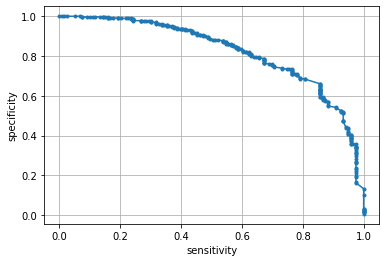

In [214]:
stats, threshes = predict_and_save(stbl, model_name='stbl')

In [215]:
stbl.rules_

[HighriskDiving <= 0.5,
 subinj_TorsoTrunk2 <= 0.5,
 subinj_Head2 <= 0.5,
 AxialLoadAnyDoc <= 0.5,
 gender_F > 0.5,
 FocalNeuroFindings2 <= 0.5 and HighriskDiving <= 0.5 and Torticollis2 <= 0.5,
 FocalNeuroFindings2 <= 0.5,
 Torticollis2 <= 0.5,
 FocalNeuroFindings <= 0.5,
 HighriskMVC <= 0.5,
 MedsRecd <= 0.5,
 PainNeck2 <= 0.5,
 LOC > 0.5,
 is_ems > 0.5,
 Immobilization2 <= 0.5,
 PainNeck2 > 0.5 and Position_S <= 0.5,
 MedsRecd2 <= 0.5,
 subinj_Head2 > 0.5,
 AlteredMentalStatus <= 0.5]

In [195]:
stats['sens'][20], stats['spec'][20]

(0.9747899159663865, 0.2665441176470588)

# look at all the results

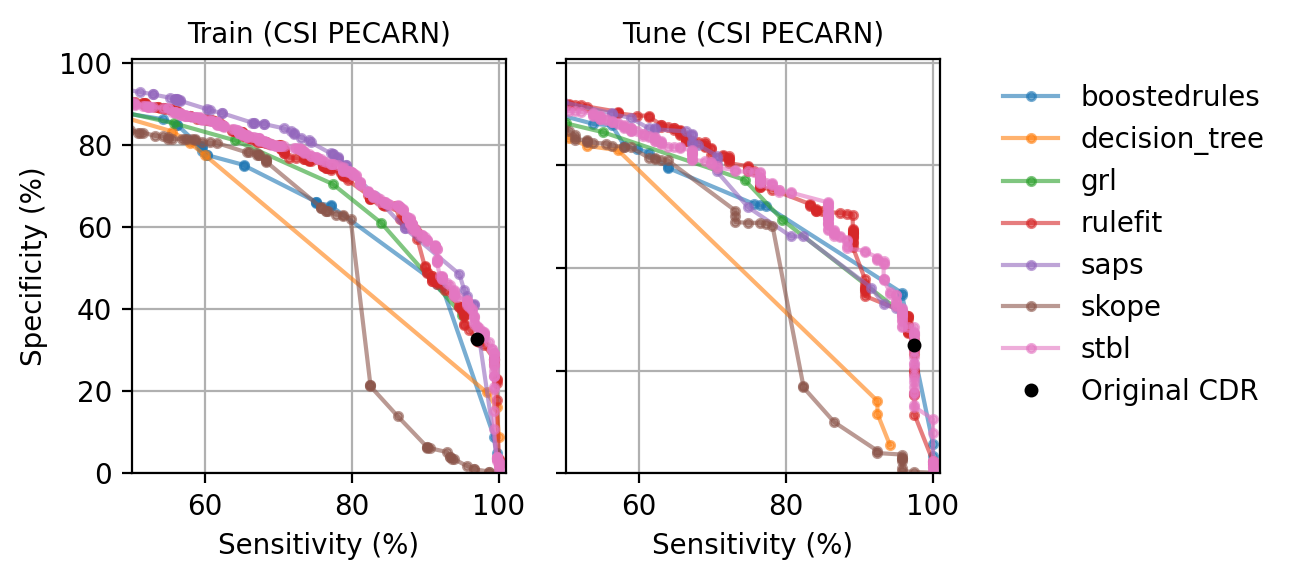

In [226]:
def plot_metrics(suffix, title=None, fs=15):
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                #         print(r)
                #                 print(r.keys())

                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=3)
                plt.xlabel('Sensitivity (%)', fontsize=fs)
                plt.ylabel('Specificity (%)', fontsize=fs)
                s = suffix[1:]
                if title is None:
                    plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
                else:
                    plt.title(title, fontsize=fs)

                # print best results
                if suffix == '_test2':
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')

    if suffix == '_train':
        plt.plot(96.96, 32.84, 'o', color='black', label='Original CDR', ms=4)
    if suffix == '_tune':
        plt.plot(97.47, 31.25, 'o', color='black', label='Original CDR', ms=4)
    plt.grid()


suffixes = ['_train', '_tune']  # _train, _test1, _test2, _cv
titles = ['Train (CSI PECARN)', 'Tune (CSI PECARN)']
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 2.5, R * 3), facecolor='w')
fs = 10
for i, suffix in enumerate(suffixes):
    ax = plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i], fs=fs)
    if i > 0:
        plt.ylabel('')
        plt.yticks([0, 25, 50, 75, 100], labels=[''] * 5)
    #         ax.yaxis.set_visible(False)
    plt.xlim((50, 101))
    plt.ylim((0, 101))
plt.tight_layout()
# plt.subplot(R, C, 1)
# plt.legend(fontsize=20)
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=fs, frameon=False)
#plt.savefig('figs/metrics_3_splits')
plt.show()